In [1]:
from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta



data_dir_mnps = config.get_property('geo_dir')
data_dir      = config.get_property('data_dir')
fb_ppl_data   = config.get_property('covid_fb')
results_dir   = config.get_property('results_dir')

In [2]:
rt_df = pd.read_csv( os.path.join(results_dir, 'bog_rt', 'rt_df_bog_confirmation.csv') )
rt_df = rt_df[rt_df["variable"]=='R']
rt_df['date'] = rt_df['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))


In [46]:
PR_2020_df

,location_id,date,attribute_name,attribute_value,type
0,colombia_bogota,2020-02-09,pagerank_gini_index,0.496280,city
1,colombia_bogota,2020-02-10,pagerank_gini_index,0.495470,city
2,colombia_bogota,2020-02-11,pagerank_gini_index,0.492339,city
3,colombia_bogota,2020-02-12,pagerank_gini_index,0.492152,city
4,colombia_bogota,2020-02-13,pagerank_gini_index,0.493053,city
...,...,...,...,...,...
672,colombia_bogota,2021-04-01,personalized_pagerank_gini_index,0.377176,city
673,colombia_bogota,2021-04-02,personalized_pagerank_gini_index,0.377542,city
674,colombia_bogota,2021-04-03,personalized_pagerank_gini_index,0.360958,city
675,colombia_bogota,2021-04-04,personalized_pagerank_gini_index,0.377754,city


In [49]:
PR_2020_df

,,location_id,attribute_value,type
date,attribute_name,,,
2020-02-09,pagerank_gini_index,colombia_bogota,0.496280,city
2020-02-10,pagerank_gini_index,colombia_bogota,0.495470,city
2020-02-11,pagerank_gini_index,colombia_bogota,0.492339,city
2020-02-12,pagerank_gini_index,colombia_bogota,0.492152,city
2020-02-13,pagerank_gini_index,colombia_bogota,0.493053,city
...,...,...,...,...
2021-04-01,personalized_pagerank_gini_index,colombia_bogota,0.377176,city
2021-04-02,personalized_pagerank_gini_index,colombia_bogota,0.377542,city
2021-04-03,personalized_pagerank_gini_index,colombia_bogota,0.360958,city


In [54]:
 pd.merge??

Signature:
pd.merge(
    left,
    right,
    how: str = 'inner',
    on=None,
    left_on=None,
    right_on=None,
    left_index: bool = False,
    right_index: bool = False,
    sort: bool = False,
    suffixes=('_x', '_y'),
    copy: bool = True,
    indicator: bool = False,
    validate=None,
) -> 'DataFrame'
Docstring:
Merge DataFrame or named Series objects with a database-style join.

The join is done on columns or indexes. If joining columns on
columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
on indexes or indexes on a column or columns, the index will be passed on.
When performing a cross merge, no column specifications to merge on are
allowed.

Parameters
----------
left : DataFrame
right : DataFrame or named Series
    Object to merge with.
how : {'left', 'right', 'outer', 'inner', 'cross'}, default 'inner'
    Type of merge to be performed.

    * left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order.


In [72]:
PR_2020_df     = pd.read_csv(os.path.join(data_dir,  'pagerank_ciudades2_2020.csv'), sep=',', parse_dates=['date']).set_index(['date','attribute_name'] )
PR_2021_df     = pd.read_csv(os.path.join(data_dir,  'pagerank_ciudades2.csv'), sep=',', parse_dates=['date']).set_index(['date','attribute_name'] )
pr_df = pd.concat([PR_2020_df, PR_2021_df]).reset_index()


In [78]:
ppr_bog_df

,date,attribute_name,location_id,attribute_value,type
356,2020-02-29,personalized_pagerank_gini_index,colombia_bogota,0.345424,city
357,2020-03-01,personalized_pagerank_gini_index,colombia_bogota,0.464163,city
358,2020-03-02,personalized_pagerank_gini_index,colombia_bogota,0.349844,city
359,2020-03-03,personalized_pagerank_gini_index,colombia_bogota,NaN,city
360,2020-03-04,personalized_pagerank_gini_index,colombia_bogota,NaN,city
...,...,...,...,...,...
746,2021-04-13,personalized_pagerank_gini_index,colombia_bogota,0.542777,city
747,2021-04-16,personalized_pagerank_gini_index,colombia_bogota,0.543110,city
748,2021-04-19,personalized_pagerank_gini_index,colombia_bogota,0.430362,city
749,2021-04-22,personalized_pagerank_gini_index,colombia_bogota,0.426548,city


In [89]:
pr_df

,date,attribute_name,location_id,attribute_value,type
0,2020-02-09,pagerank_gini_index,colombia_bogota,0.496280,city
1,2020-02-10,pagerank_gini_index,colombia_bogota,0.495470,city
2,2020-02-11,pagerank_gini_index,colombia_bogota,0.492339,city
3,2020-02-12,pagerank_gini_index,colombia_bogota,0.492152,city
4,2020-02-13,pagerank_gini_index,colombia_bogota,0.493053,city
...,...,...,...,...,...
746,2021-04-13,personalized_pagerank_gini_index,colombia_bogota,0.542777,city
747,2021-04-16,personalized_pagerank_gini_index,colombia_bogota,0.543110,city
748,2021-04-19,personalized_pagerank_gini_index,colombia_bogota,0.430362,city
749,2021-04-22,personalized_pagerank_gini_index,colombia_bogota,0.426548,city


In [106]:
ppr_bog_df = pr_df[pr_df["attribute_name"]=="personalized_pagerank_gini_index"]
pr_bog_df  = pr_df[pr_df["attribute_name"]=="pagerank_gini_index"]

ppr_bog_df = ppr_bog_df.set_index('date') #
ppr_bog_df = ppr_bog_df[["attribute_value"]].resample('1D').mean()#.interpolate(method='polynomial', order=2)
ppr_bog_df = ppr_bog_df.interpolate(method='linear', order=2)
ppr_bog_df = ppr_bog_df.reset_index()
ppr_bog_df

,date,attribute_value
0,2020-02-29,0.345424
1,2020-03-01,0.464163
2,2020-03-02,0.349844
3,2020-03-03,0.343840
4,2020-03-04,0.337836
...,...,...
417,2021-04-21,0.427820
418,2021-04-22,0.426548
419,2021-04-23,0.429051
420,2021-04-24,0.431553


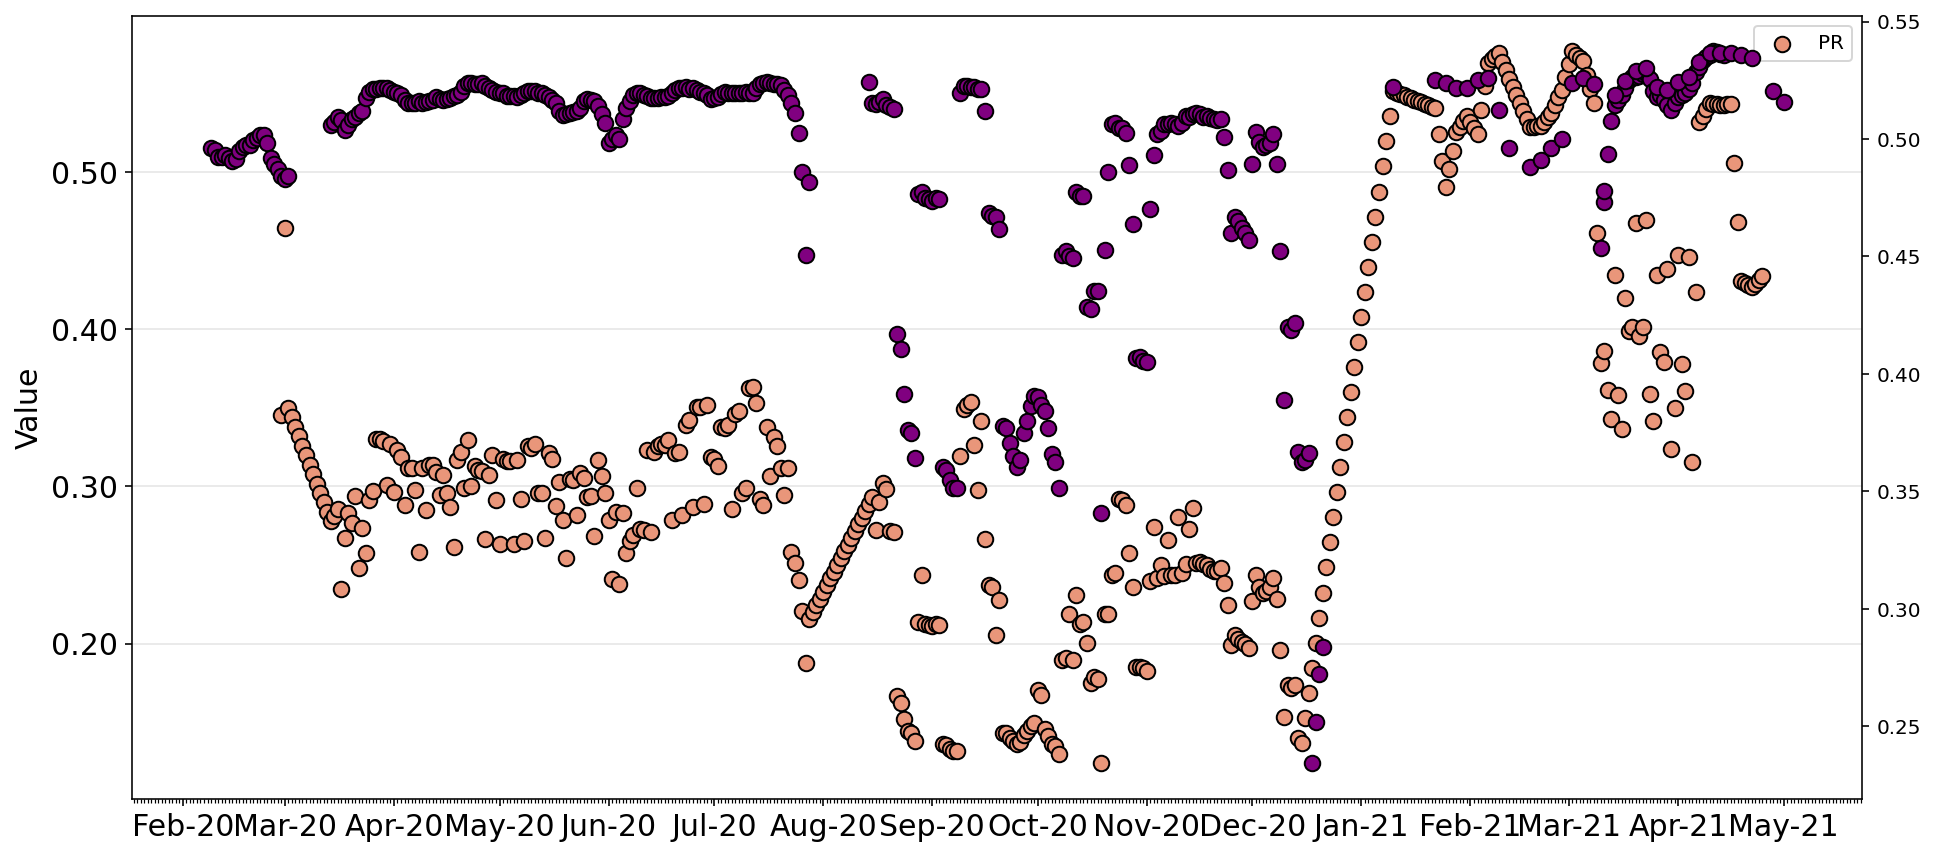

In [108]:
%config InlineBackend.figure_format ='retina'

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
ax.scatter(ppr_bog_df["date"], ppr_bog_df["attribute_value"], facecolor='darksalmon', edgecolor='k', s=60, label='PR')
ax.scatter(pr_bog_df["date"], pr_bog_df["attribute_value"], facecolor='purple', edgecolor='k', s=60, label='PPR')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.tick_params(axis='both', labelsize=15)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.set_ylabel('Value', fontsize=15)
ax.legend()